<a href="https://colab.research.google.com/github/zClarkk/Medical-Deep-Learning-Collection/blob/main/Weakly_Supervised_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Deep Learning
## Exercise 4: Weakly-Supervised Visualization

The goal of this exercise is to implement methods that allow to gain insights which parts of an input image to a Deep Neural Network are pivotal for its classification decision. Because of their conception as black-box-system, especially in Medical Imaging this is important for user acceptance.

![explainability](https://drive.google.com/uc?export=view&id=1oDUfMmOpopV8Dnv4rvHmqmxMcIK8JLYI)

In [ ]:
!pip install wget
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=bdc1d3abad52e19c5b884e23d178f829d7cf0a2e18b2e9288dbd7e1c325a72aa
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import matplotlib.cm as mpl_color_map
import os
import wget
import zipfile
from tqdm.notebook import trange, tqdm

%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
dataset_url = 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'

def get_data(data_url):
    filename = './MDL3_data.zip'
    if not os.path.exists(filename):
        filename = wget.download(data_url)
    zipfile.ZipFile(filename,'r').extractall()

get_data(dataset_url)

In [ ]:
# Function for Heatmap Overlays (expects gray-scale image as numpy and heatmap as torch array)
def overlayParula(grayim_numpy: np.ndarray, heatmap_torch: torch.Tensor, smooth : bool=False):

    heat_max = torch.kthvalue(heatmap_torch.view(-1), int(.95*heatmap_torch.numel()))[0]
    heat_min = torch.min(heatmap_torch)
    heatmap_torch = torch.clamp((heatmap_torch-heat_min)/(heat_max-heat_min),0,1)
    if(smooth==True):
        heatmap_torch = F.avg_pool2d(F.avg_pool2d(F.max_pool2d(heatmap_torch.unsqueeze(0).unsqueeze(0),3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze()


    x = np.linspace(0.0, 1.0, 256)
    rgb_jet = mpl_color_map.get_cmap(plt.get_cmap('jet'))(x)[:,:3]
    rgb_gray = mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:,:3]
    #rgb_viridis
    rgb_heat = rgb_jet[(heatmap_torch*255).numpy().astype('uint8'),:]
    rgb_base = rgb_gray[(grayim_numpy*255).astype('uint8'),:]

    rgb0 = (rgb_heat*127.5+rgb_base*127.5).astype('uint8')
    weight = torch.tanh((heatmap_torch-0.5)*3)*0.5+0.5
    alpha = torch.clamp(1.0 - 0.5*weight,0,1.0)
    overlay = rgb_base*alpha.unsqueeze(2).numpy() + rgb_heat*(1.0-alpha).unsqueeze(2).numpy()

    return overlay

# Function to compute the number of trainable parameters in a given model
def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

# Function to compute the Dice value given the ground truth segmentation of a slice
# and the guided_backpropagation_map or the CAM map as <pred>
def oracle_dice(pred,gt_th):
    val,idx = torch.sort(pred.data.flatten(),descending=True)
    gt_sort = gt_th.flatten()[idx]
    intersect = torch.cumsum(gt_sort,0).float()
    cardinal = (gt_th.flatten()>0.5).float().sum()+torch.arange(pred.numel(), device=gt_th.device).float()
    all_dices = 2*intersect/torch.clamp(cardinal,min=.001)
    return all_dices.max(),val[all_dices.argmax()]

## Task 0 (15 points): Implement dataset and visualize the given pancreas train & test data
We start with implementing the `PancreasDataSet`, which loads the training and test data respectively to its `mode` (`train` or `test`). For training data only the labels are given, for the test datasets also segmentation masks are provided. Because our pretrained CNN on ImageNet expects an RGB-image, we stack three neighboring slices of the CT as feature channels.
The training data are given as a list of tensors with shape $[64\times3\times224\times224]$ for the image and $[64]$ for the labels.
+ load the data and its labels accordingly to the dataset's mode and concatenate each list to one tensor in dimension $N$ using `torch.cat`
+ divide the images with 255 to map them to $[0, 1]$
+ if `mode=='test'` load the segmentation masks and concatenate them like above
+ z-standardize the images to match the ImageNet value distribution with the provided statistic
+ complete the `__len__` and `__getitem__` functions
    + **NOTE** the number of returned data differs between the `mode`s. Please use following order for the return statements: images, labels, (segmentations)


In [ ]:
torch.cat(torch.load("test_imgs.pth")).shape

torch.Size([320, 3, 224, 224])

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PancreasDataSet(Dataset):
    def __init__(self, mode: str, normalize: bool=True):
        """
        constructor
        :param mode: decides whether the training or test split should be loaded
        :param normalize: normalize the images with the given statistics
        """
        assert mode in ['train', 'test']
        self.mode = mode
        super(PancreasDataSet, self).__init__()

        # load data
        self.imgs = torch.cat(torch.load(f'{mode}_imgs.pth'))/255
        # load lables
        self.lables = torch.cat(torch.load(f'{mode}_labels.pth'))

        if mode == 'test':
            # load segmentations
            self.segmentations = torch.cat(torch.load("test_segmentations.pth"))
            assert len(self.imgs) == len(self.lables) == len(self.segmentations)
        assert len(self.imgs) == len(self.lables)

        # normalize data
        if normalize:
            # Below we provide the mean and std values from the ImageNet data
            means = torch.Tensor([0.485, 0.456, 0.406]).unsqueeze(0).unsqueeze(2).unsqueeze(3)
            stds = torch.Tensor([0.229, 0.224, 0.225]).unsqueeze(0).unsqueeze(2).unsqueeze(3)

            self.imgs = (self.imgs-means)/stds

    def __getitem__(self, index):
        if self.mode == 'train':
            return self.imgs[index], self.lables[index]
        else:
            return self.imgs[index], self.lables[index], self.segmentations[index]

    def __len__(self):
        return len(self.imgs)

In [ ]:
### Visualize some random input training & test slices

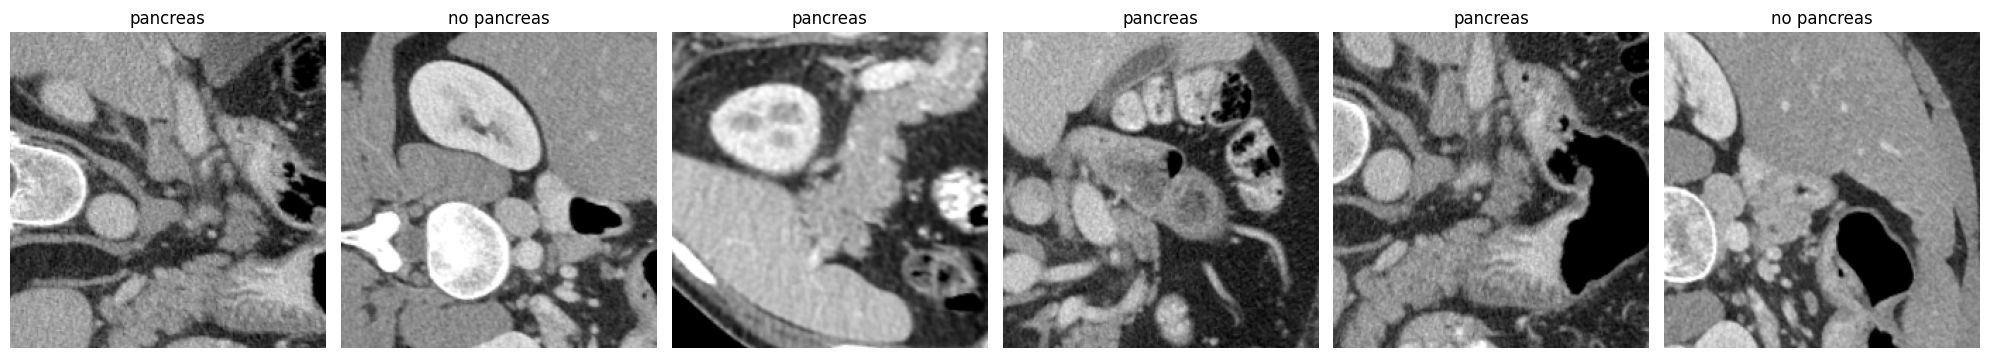

In [ ]:
ds = PancreasDataSet('test', normalize=False)
label = ['no pancreas', 'pancreas']
n_plots = 6
rnd_idx = torch.randperm(len(ds))[:n_plots]

fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))
for i, idx in enumerate(rnd_idx):
    img, lbl, _ = ds[idx]
    axs[i].imshow(img[1], cmap='gray')
    axs[i].set_title(label[lbl.item()])
    axs[i].set_axis_off()
fig.tight_layout()

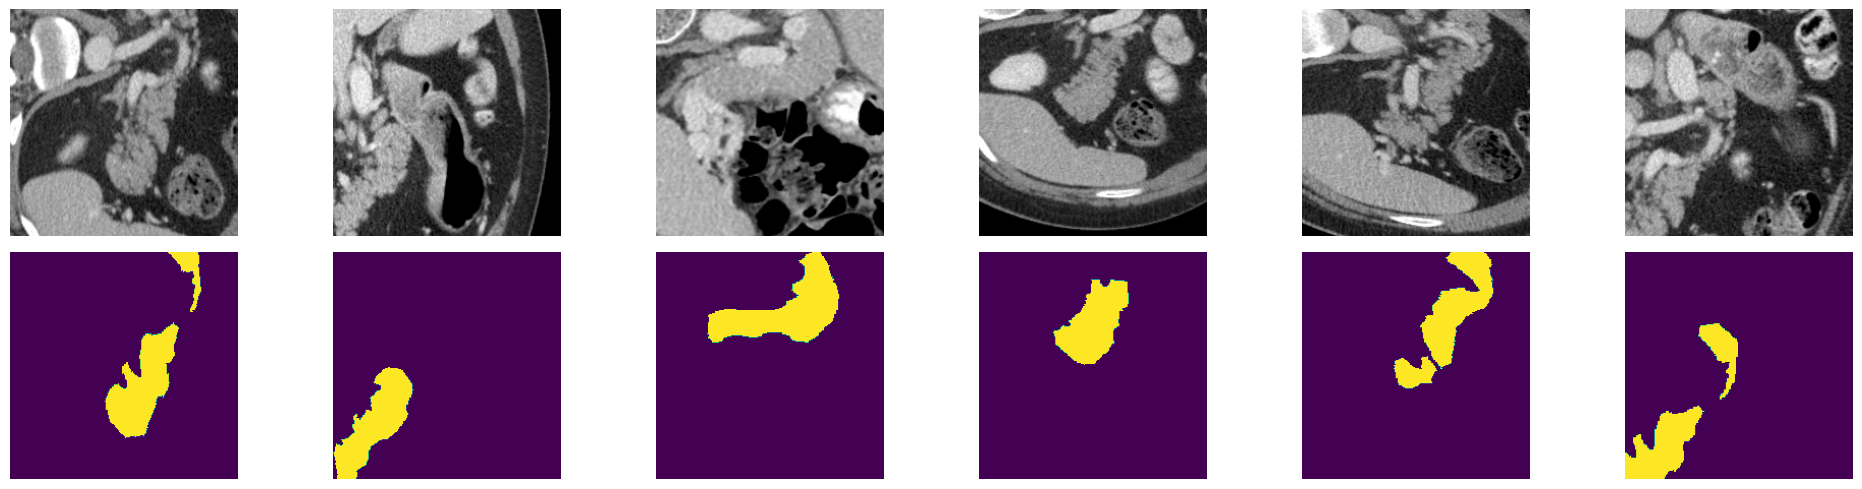

In [ ]:
rnd_idx = torch.arange(len(ds))[ds.lables == 1]
rnd_idx = rnd_idx[torch.randperm(len(rnd_idx))[:n_plots]]

fig, axs = plt.subplots(2, n_plots, figsize=(20, 5))
for i, idx in enumerate(rnd_idx):
    axs[0, i].imshow(ds.imgs[idx, 1], cmap='gray')
    axs[0, i].set_axis_off()

    axs[1, i].imshow(ds.segmentations[idx])
    axs[1, i].set_axis_off()
fig.tight_layout()

## Task 1 (25 points): Finetune a pretrained ResNet on the given data
Before we can fine tune the pretrained CNN on our data, we have to modify its architecture to our needs.
+ load the **pretrained** ResNet18 from the torchvision model zoo
+ get familiar with the architecture's structure
    + print its layers with their settings using the `print` function
    + check the corresponding output shapes with `torchinfo.summary`

In [ ]:
from torchinfo import summary
# load model
model = models.resnet18(pretrained=True)

summary(model,(64,3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 1000]                --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

With foresight to the gradCAM method, we need the last feature layer to have a sufficiently large spatial dimensions therefore we need to replace the ResNet.Layer4 Sequential block with an identity operation (`nn.Identity`). Since in addition to a larger spatial output of the last feature layer, we also want a more lightweight model, we modify the building blocks of Layer3:

1. Replace `conv1` in `layer3[0]` with a Conv2D: (in=128,out=256,k_sz=3, stride=1, pad=1, bias=False)
2. Replace `conv2` in `layer3[0]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
3. Replace `downsample[0]` in `layer3[0]` with a Conv2D: (in=128,out=256,k_sz=1, stride=1, pad=0, bias=False)
4. Replace `conv1` in `layer3[1]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
5. Replace `conv2` in `layer3[1]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)

Finally: replace the fully connected layer: Inspect the number of input & output channels for the ImageNet classification task and modify this layer accordingly to our "(presence/absence) of the pancreas" classification problem.

Now, we have a ResNet14. Check its architecture using `summary`. You should obtain a total count of $2.783.298$ parameters.

In [ ]:
print(model.fc)


Linear(in_features=512, out_features=1000, bias=True)


In [ ]:
# TODO replace the 4th layer with an identity mapping
model.layer4 = nn.Identity()

# TODO: replace the modules according to the description given above
model.layer3[0].conv1 = nn.Conv2d(128,256,3,1,1,bias=False)
model.layer3[0].conv2 = nn.Conv2d(256,256,3,stride=1,padding=2,dilation=2,bias=False)
model.layer3[0].downsample[0] = nn.Conv2d(128,256,1,stride=1,padding=0,bias=False)
model.layer3[1].conv1 = nn.Conv2d(256,256,3,stride=1,dilation=2,padding=2,bias=False)
model.layer3[1].conv2 = nn.Conv2d(256,256,3,stride=1,dilation=2,padding=2,bias=False)
# TODO: replace the fully connected layer
model.fc = nn.Linear(256,2)

# TODO: print the summary
summary(model,(64,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

Now let's finetune the ResNet14 to our training data:
+ create two dataloader (hint: set `pin_memory=True` for speed up during CPU→GPU transfer)
    + choose a batch size of 32 for training and shuffle the dataset after every epoch
    + you can double the batch size for testing
- use Adam in combination with an exponential learning rate scheduler ($\gamma=0.95$) and cross entropy
- you should easily achieve accuracy scores on the training data of > 0.98 after 3 epochs
- your validation accuracy should be ~80% after 10 epochs

In [ ]:
dl_train = DataLoader(PancreasDataSet('train', normalize=True), batch_size=32,pin_memory=True,shuffle=True,drop_last=False)
dl_test =  DataLoader(PancreasDataSet('test', normalize=True), batch_size=64,pin_memory=True)

model.cuda()

num_epochs = 10

# optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# learning rate scheduler
lr_scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

# criterion
criterion = nn.CrossEntropyLoss().cuda()

# for reproducibility (do not change)
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(num_epochs, device='cuda')
train_acc = torch.zeros_like(train_loss)

test_loss = torch.zeros_like(train_loss)
test_acc = torch.zeros_like(train_loss)

# for num_epochs
for epoch in trange(num_epochs, unit='epoch'):

    # train mode
    model.train()

    # for each mini-batch
    for input, target in dl_train:
        input = input.cuda()
        target = target.cuda()



        # forward + backward + optimize
        output = model(input)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # statistics
        train_loss[epoch] += loss.detach()
        train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

    # update learning rate
    lr_scheduler.step()
    # todo

    train_loss[epoch] /= len(dl_train)
    train_acc[epoch] /= len(dl_train)

    # output
    tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

    # validate
    with torch.no_grad():

        # eval mode
        model.eval()

        # for each mini-batch
        for input, target, _ in dl_test:
            input = input.cuda()
            target = target.cuda()

            # forward
            output = model(input)
            loss = criterion(output,target)

            # statistics
            test_loss[epoch] += loss.detach()
            test_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

        test_loss[epoch] /= len(dl_test)
        test_acc[epoch] /= len(dl_test)

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, test_loss[epoch].item(), test_acc[epoch].item()))

torch.save(model, 'pancreas_model.pt')

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.6372 accuracy: 0.6359
Epoch 0 (valid) -- loss: 0.6139 accuracy: 0.6344
Epoch 1 (train) -- loss: 0.4755 accuracy: 0.8297
Epoch 1 (valid) -- loss: 0.5376 accuracy: 0.7438
Epoch 2 (train) -- loss: 0.3981 accuracy: 0.8867
Epoch 2 (valid) -- loss: 0.5262 accuracy: 0.7250
Epoch 3 (train) -- loss: 0.3477 accuracy: 0.9086
Epoch 3 (valid) -- loss: 0.5173 accuracy: 0.7094
Epoch 4 (train) -- loss: 0.3107 accuracy: 0.9367
Epoch 4 (valid) -- loss: 0.5079 accuracy: 0.7031
Epoch 5 (train) -- loss: 0.2799 accuracy: 0.9465
Epoch 5 (valid) -- loss: 0.4873 accuracy: 0.7156
Epoch 6 (train) -- loss: 0.2482 accuracy: 0.9637
Epoch 6 (valid) -- loss: 0.4840 accuracy: 0.7188
Epoch 7 (train) -- loss: 0.2300 accuracy: 0.9715
Epoch 7 (valid) -- loss: 0.4687 accuracy: 0.7469
Epoch 8 (train) -- loss: 0.2043 accuracy: 0.9836
Epoch 8 (valid) -- loss: 0.4450 accuracy: 0.7719
Epoch 9 (train) -- loss: 0.1886 accuracy: 0.9887
Epoch 9 (valid) -- loss: 0.4532 accuracy: 0.7563


![cam](https://drive.google.com/uc?export=view&id=1CBjTBKCdTHFi6MDoz0hJ1y-Faat56Krz)
## Task 2 (30 points): implement the CAM method
Now that we have our trained ResNet14 at hand, we want to visualize the class activation map (CAM).
Therefore, we need to implement the following steps:

+ Beforehand, the fully connected layer operated on 256-channel images without spatial dimensions only due to the `nn.AdaptivePooling` layer. Now, we want to weight each of the $28\times28$ spatial features with their 256-channels using the trained weights from the fully connected layer. In order to do so, extract the weights for the class activation map from the fully connected layer's weight (remember that we are only interested in the weights for the 'pancreas presence' class).
+ Since we are interested in the last convolutional feature layer output, we want to omit the avg_pool & fc layer. (Hint: use `torch.nn.Sequential(*list(model.children())[:-k])`)

In [ ]:
# load the net
model = torch.load('pancreas_model.pt')
# extract weights for cam
cam_weight = model.fc.weight[1]
# remove the avg and fc layer
truncated_model = torch.nn.Sequential(*list(model.children())[:-2])

In [ ]:
# provided function for plotting the activation heatmaps and comparing them to the ground truth
def plot_activations(img: torch.Tensor, activation_heatmap: torch.Tensor, segmentation: torch.Tensor):

    img = img[1].squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(overlayParula(img, activation_heatmap.cpu().squeeze(), smooth=True))
    axs[0].set_axis_off()
    axs[0].set_title('prediction')

    axs[1].imshow(overlayParula(img, segmentation.cpu(), smooth=False))
    axs[1].set_axis_off()
    axs[1].set_title('ground truth')

Next, we want to generate our segmentation from the latent space. Therefore
+ feed the normalized image through our modified model
+ generate the CAM, therefore
    + multiply each feature map with its corresponding weight of the fully connected classifier
    + sum over all feature maps to create a CAM
    + upsample the CAM to the spatial dimension of the input image
+ visualize and compare the CAM with the given ground truth using the provided `plot_activations` function.
+ Finally, use the `oracle_dice` function to compute the DICE score (~0.6mean) between the ground truth and the CAM-based segmentation - remember: using only weak labels during the training stage!

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-4-49ed5baf74a2>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb_jet = mpl_color_map.get_cma

mean dice: 0.5283628702163696


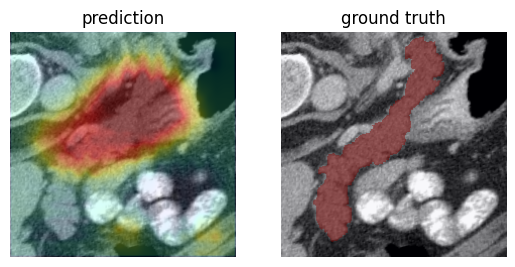

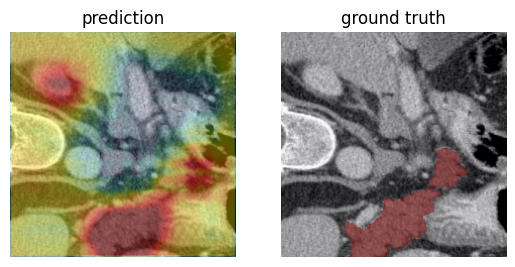

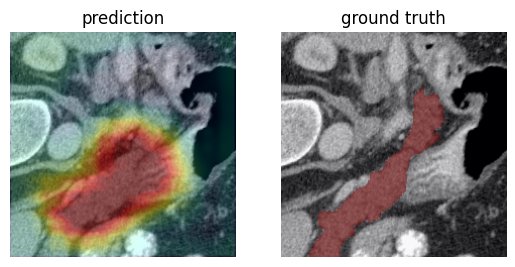

In [ ]:
dice_all = []
import torchvision.transforms as T
for test_idx in range(256,262,2):
    # skip img without pancreas
    if(ds.lables[test_idx]==0):
        continue

    img_normalized = dl_test.dataset.imgs[test_idx].unsqueeze(0).cuda()
    img = ds.imgs[test_idx].cuda()
    seg = ds.segmentations[test_idx].cuda()

    with torch.no_grad():
        # feed the test image through the modified net
        feature_map = truncated_model(img_normalized)
        tensor_cam = feature_map*cam_weight.unsqueeze(0).unsqueeze(2).unsqueeze(3)

        cam = tensor_cam.mean(1)
        res = T.Resize(224)
        cam = res(cam[None,:,:])
    dice_all.append(oracle_dice(cam,seg)[0])

    plot_activations(img,cam,seg)


print('mean dice:', torch.stack(dice_all).mean().item())

## Task 3 (30 points): implement the guided backpropagation
(see also: http://blog.qure.ai/notes/deep-learning-visualization-gradient-based-methods)

The idea of GuidedBackprop is to supress gradient flow at positions where either of input or incoming gradients were negative.
Luckily, implementing this idea in PyTorch is quite comfortable, since it allows to write own layers - and especially also to define the backpropagation step on the Python-level, i.e. without having to code in CUDA explicitly, when ultimate performance is not necessary.

1. In order to use our pretrained ResNet14, we need to replace the ReLU functions by customized ReLUs that suppress the negative gradient flows according to the above stated cases.

2. Afterward, we need to implement to guided backpropagation steps.

### Implementing the custom ReLU-Layer
(See https://pytorch.org/docs/stable/notes/extending.html for further examples on how to implement custom functions & layers and http://cs231n.github.io/optimization-2/#backprop to refresh your knowledge on local backpropagation using the chain rule if needed.)

The cell below contains a simple example of a modified square function. Instead of computing the derivative of $x^2$ as $\frac{\partial}{\partial x}(x^2) = 2x$, our the customized square function sets this to $4x$ during the backward step.

In [ ]:
#example for a custom function and its nn-module
class SquareFunction(torch.autograd.Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = input**2
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        grad_input = grad_output*4.0*input[0].float()
        return grad_input


class SquareLayer(torch.nn.Module):
    def __init__(self):
        super(SquareLayer, self).__init__()

    def forward(self, x):
        SqFct = SquareFunction.apply
        x = SqFct(x)
        return x


test = torch.arange(4).view(2,2).float()
test.requires_grad = True

mySQLayer = SquareLayer()
out = mySQLayer(test)
print('input:', test)
print('output:', out)
back = torch.ones(2,2)
out.backward(back)
print('gradient:', test.grad)

input: tensor([[0., 1.],
        [2., 3.]], requires_grad=True)
output: tensor([[0., 1.],
        [4., 9.]], grad_fn=<SquareFunctionBackward>)
gradient: tensor([[ 0.,  4.],
        [ 8., 12.]])


![guided backpropagation](https://drive.google.com/uc?export=view&id=1kC5h6E9j2lXVLZw0cvkow4N_IcDi1deY)

Based on the customized square function as an example, you now have to implement a custom `GradReluLayer`, that cancels out gradient flow where either the input values or the gradient values at the layers output are negative (see guided backpropagation in figure above).
To verify your implementation, also write your own sanity check.

In [ ]:
#define custom relu function and its nn-module
class GradReluFunction(torch.autograd.Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = input * (input >= 0)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        grad_input = (grad_output * (grad_output >= 0))*(input[0] >= 0)
        # todo
        return grad_input


class GradReluLayer(torch.nn.Module):
    def __init__(self):
        super(GradReluLayer, self).__init__()

    def forward(self, x):
        RFct = GradReluFunction.apply
        x = RFct(x)
        return x

test = torch.arange(4).view(2,2).float() - 2
test.requires_grad = True

mySQLayer = GradReluLayer()
out = mySQLayer(test)
print('input:', test)
print('output:', out)
back = torch.ones(2,2)
back[1][1] = -1
out.backward(back)
print('gradient:', test.grad)

input: tensor([[-2., -1.],
        [ 0.,  1.]], requires_grad=True)
output: tensor([[-0., -0.],
        [0., 1.]], grad_fn=<GradReluFunctionBackward>)
gradient: tensor([[0., 0.],
        [1., -0.]])


In [ ]:
GReLU = GradReluLayer()

t_in1 = torch.Tensor([[-2,1],[2,2]])
t_in1.requires_grad = True
t_out1 = GReLU(t_in1)

t_out1.backward(torch.Tensor([[-1,1],[1,-1]]))

print('input:', t_in1)
print('output:', t_out1)
print('gradient:', t_in1.grad)
#should zero all negative gradients

# write your own sanity check!

input: tensor([[-2.,  1.],
        [ 2.,  2.]], requires_grad=True)
output: tensor([[-0., 1.],
        [2., 2.]], grad_fn=<GradReluFunctionBackward>)
gradient: tensor([[-0., 1.],
        [1., -0.]])


In [ ]:
#GIVEN FUNCTION to replace all default ReLUs
def replaceFunc(model):
    if(isinstance(model,nn.Sequential)):
        if(len(model)>1):
            for i in range(len(model)):
                replaceFunc(model[i])
    for i,j in model._modules.items():
        if(isinstance(j,nn.ReLU)):
            model._modules[i] = GradReluLayer()

        if(isinstance(j,nn.Sequential)):
            model._modules[i] = replaceFunc(model._modules[i])
    return model

Having the customized ReLU-layer at hands, we are now able to implement the guided backward propagation scheme.
1. Define a function `guided_backprop` that expects
    + a test_image of size [1, 3, 224, 224]
    + the pretrained ResNet with customized ReLUs
    + a target_class
    + the output will be the guided gradient image
2. as a first step when calling the function, make sure that gradients will be computed for the input image
3. forward propagate the image through the pretrained model (in evaluation mode!)
4. having constructed the autograd graph, we set the gradients of the model to zero
5. next, we backpropagate a one-hot-tensor (for the correct class) through this graph towards the input. Therefore, we set our one-hot-tensor as `gradient` in the `backward` call.
6. finally, return the summed along the channels (absolute values) gradient image as output

In [ ]:
def guided_backprop(input_img, pretrained_model, target_class):
    #APPLY GUIDED BACKPROP!

    # ensure gradient flow up until input
    # todo
    input_img.requires_grad_()
    #important: set model in evaluation mode!
    # todo
    pretrained_model.eval()
    # forward pass
    # todo
    output = pretrained_model(input_img)
    # create one-hot target for backprop
    # todo
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1

    # zero_grad
    # todo
    pretrained_model.zero_grad()
    # backward pass
    # todo
    output.backward(gradient=one_hot)
    # sum along abs values on channels
    # todo
    guided_gradients = input_img.grad.data
    guided_grad = torch.sum(torch.abs(guided_gradients), dim=1, keepdim=True)
    return guided_grad


Plug all parts together and visualize the guided backpropagation map for a test image.
Choosing the same test patient as for CAM and once again computing the DICE score, you should achieve values ~0.4+.

torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])


<ipython-input-4-49ed5baf74a2>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb_jet = mpl_color_map.get_cmap(plt.get_cmap('jet'))(x)[:,:3]
<ipython-input-4-49ed5baf74a2>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb_gray = mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:,:3]


mean dice: 0.4026338458061218


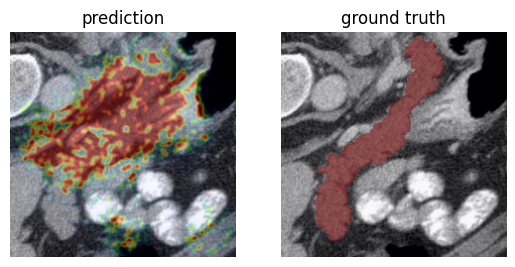

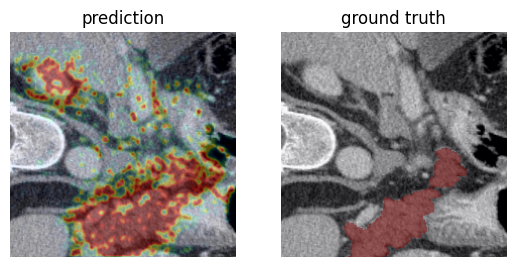

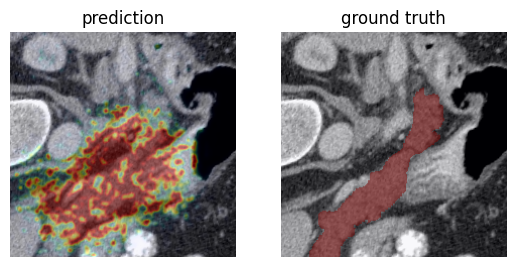

In [ ]:
# load the net
model = torch.load('pancreas_model.pt')
model = replaceFunc(model)
# replace its relu functions
# todo

torch.manual_seed(50)
dice_all = []

for test_idx in range(256,262,2):
    # skip img without pancreas
    if(ds.lables[test_idx]==0):
        continue

    img_normalized = dl_test.dataset.imgs[test_idx].unsqueeze(0).cuda()
    img = ds.imgs[test_idx].cuda()
    seg = ds.segmentations[test_idx].cuda()

    # call the guided backprop funktion
    # todo
    cam = guided_backprop(img_normalized,model,ds.lables[test_idx])
    # visualize the map
    # todo
    print(cam.shape)
    # compute the dice value & append it to dice_all
    # todo
    dice_all.append(oracle_dice(cam,seg)[0])

    plot_activations(img.detach(),cam,seg)

print('mean dice:',torch.mean(torch.stack(dice_all)).item())

# Bonus task: Explainable pneumonia classification (10 bonus points)
For the bonus task you can implement the CAM method for the pneumonia classification of the very first MDL exercise sheet (Exercise 0).
Therefore
+ adapt the CNN accordingly to become usable with the CAM method
+ extract the CAMs for the **test** data with the index $i\in\{0, 14, 15, 26, 27, 33, 34\}$ (including only samples with pneumonia)
+ visualize them with matplotlib or a similar plotting library of your choice
+ have a closer look at the activation maps. Do you notice something, that indicates an overfitting on the dataset or a false decision base of the CNN for the classification? **Write some short sentences!**

Your results should look similar to these plots:

![cam0](https://drive.google.com/uc?export=view&id=18JBnp637Z6WKHpiQmFUWlGHb-cBfnaEH)
![cam14](https://drive.google.com/uc?export=view&id=1U1os6B4m-FAxCq4TB50jlnTZb5HD9Kn7)
![cam15](https://drive.google.com/uc?export=view&id=1IyNItiLOvbFD-Uqs8yVMM98-4c6rtqtW)
![cam26](https://drive.google.com/uc?export=view&id=1iDmRY3gRoeTwXN6Njrhv5mZqR_Jdvcco)
![cam27](https://drive.google.com/uc?export=view&id=1RxxEgtK47IBVWBoGQR9QusUWYXhiVlxD)
![cam33](https://drive.google.com/uc?export=view&id=1hhmSVIKkecQvmFnjKPo_CnhGMRtwjoaJ)
![cam34](https://drive.google.com/uc?export=view&id=14sWeMsTnSx5V2tLcynXvT8qAb2MVhMHA)

# CNN

In [ ]:
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ConvBlock, self).__init__()
        self.layer = nn.Sequential(
            # TODO
            # 1st layer group
            nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(),

            # 2nd layer group
            nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(),

            # max pooling
            nn.MaxPool2d(2)
        )

    # Given
    def forward(self, x):
        return self.layer(x)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(1, 8),
            ConvBlock(8, 16),
            ConvBlock(16, 32),
        )

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(32, 8, bias=False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.avg_pool(x)
        x = self.classifier(torch.flatten(x, start_dim=1))

        return x

# DS

In [ ]:
import wget
from os.path import exists
from torch.utils.data import Dataset


class PneumoniaXRayDataset(Dataset):
    def __init__(self, mode: str):
        super(PneumoniaXRayDataset, self).__init__()
        # load data
        data_file = 'pneumonia_detection_data_img.pth'
        label_file = 'pneumonia_detection_data_label.pth'

        if not exists(data_file):
            data_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/7Re8XdKCxpTZDk2/download/pneumonia_detection_data_img.pth')
        if not exists(label_file):
            label_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/XgccQesxFeT9EqE/download/pneumonia_detection_data_label.pth')

        img = torch.load(data_file)
        lbl = torch.load(label_file)

        # store statistic of whole dataset
        self.num_data = len(lbl)
        self.num_lbl = torch.bincount(lbl)

        torch.manual_seed(42)
        rand_idx = torch.randperm(len(lbl))

        # split data
        if mode == 'train':
            self.idx = rand_idx[:4500]
        elif mode == 'val':
            self.idx = rand_idx[4500:5000]
        elif mode == 'test':
            self.idx = rand_idx[5000:]
        else:
            raise ValueError(f'unknown mode: {mode}. Valid modes are train, val and test')

        self.img = img[self.idx]
        self.lbl = lbl[self.idx]

    def __len__(self):
        return len(self.lbl)

    def __getitem__(self, idx):
        return self.img[idx], self.lbl[idx]

In [ ]:
ds = PneumoniaXRayDataset('train')
label_count = ds.num_lbl

In [ ]:
P = label_count/label_count.sum()
w = torch.sqrt(torch.pow(P, -1))

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm


train_dl = DataLoader(dataset=PneumoniaXRayDataset(mode='train'),
                      batch_size=32, shuffle=True, drop_last=True)
val_dl = DataLoader(dataset=PneumoniaXRayDataset(mode='val'), batch_size=64, drop_last=False)

# Train

In [ ]:
num_epoch = 30
train_loss = torch.zeros(num_epoch)
train_acc = torch.zeros(num_epoch)

val_loss = torch.zeros(num_epoch)
val_acc = torch.zeros(num_epoch)

In [ ]:
device = "cuda"
mdl = CNN().to(device)
optimizer = torch.optim.Adam(mdl.parameters())
criterion = nn.CrossEntropyLoss(weight=w.to(device))

In [ ]:
for epoch in trange(num_epoch, unit='epochs'):
    mdl.train()
    for img, lbl in train_dl:
        # TODO
        img = img.to(device)
        lbl = lbl.to(device)

        logits = mdl(img)
        loss = criterion(logits, lbl)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss[epoch] += loss.detach().cpu()
        train_acc[epoch] += torch.sum(torch.argmax(logits, dim=1) == lbl).cpu()

    mdl.eval()
    for img, lbl in val_dl:
        # TODO
        img = img.to(device)
        lbl = lbl.to(device)

        with torch.no_grad():
            logits = mdl(img)
        loss = criterion(logits, lbl)

        val_loss[epoch] += loss.cpu()
        val_acc[epoch] += torch.sum(torch.argmax(logits, dim=1) == lbl).cpu()

train_loss /= len(train_dl) * train_dl.batch_size
train_acc /= len(train_dl) * train_dl.batch_size

val_loss /= len(val_dl.dataset)
val_acc /= len(val_dl.dataset)

  0%|          | 0/30 [00:00<?, ?epochs/s]

In [ ]:
def plot_training_progress(train_loss: torch.Tensor, train_acc: torch.Tensor, val_loss: torch.Tensor, val_acc: torch.Tensor):
    labels = ['training', 'validation']
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(torch.arange(len(train_loss), device='cpu'), train_loss.cpu(), val_loss.cpu())
    axs[0].legend(labels)
    axs[0].set_title('Loss')
    axs[0].set_ylabel('crossentropy loss')

    axs[1].plot(torch.arange(len(train_acc), device='cpu'), train_acc.cpu(), val_acc.cpu())
    axs[1].legend(labels)
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('epoch')

    plt.show()

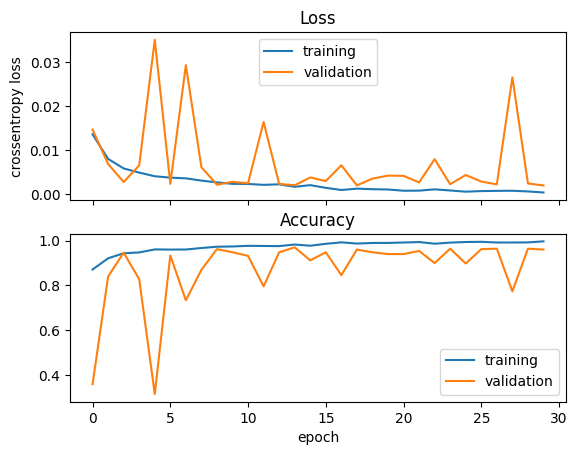

In [ ]:
plot_training_progress(train_loss, train_acc, val_loss, val_acc)

In [ ]:
test_ds = PneumoniaXRayDataset('test')

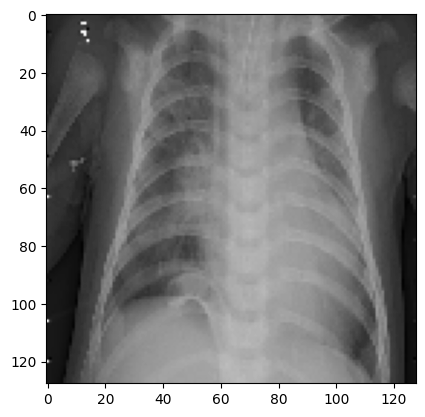

In [ ]:
plt.imshow(test_ds.img[0].squeeze(),cmap="gray")

In [ ]:
def plot_cam(img: torch.Tensor, activation_heatmap: torch.Tensor, idx, lbl):

    img = img.squeeze().cpu().detach().numpy()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img,cmap="gray")
    plt.title(f'image idx: {idx}')
    plt.subplot(1,2,2)
    plt.imshow( activation_heatmap.cpu().squeeze(), 'jet')
    plt.title(f'Grad-CAM')
    plt.show()


In [ ]:
cherry_pick = [0,14,15,26,27,33,34]

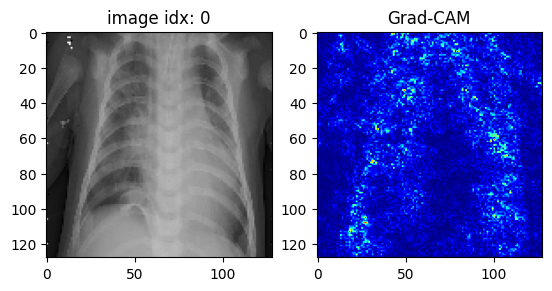

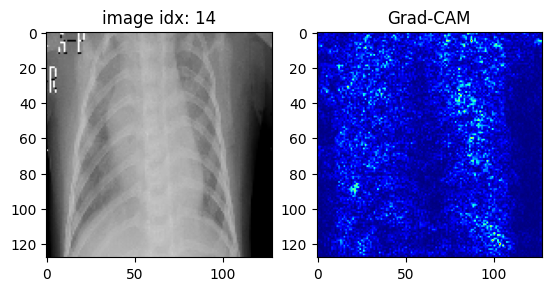

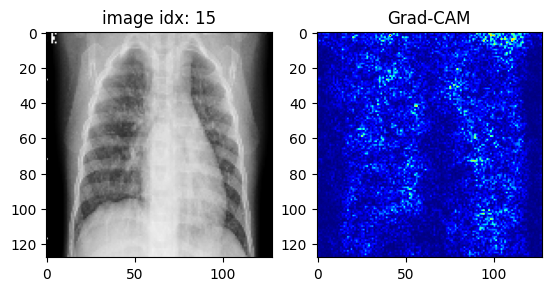

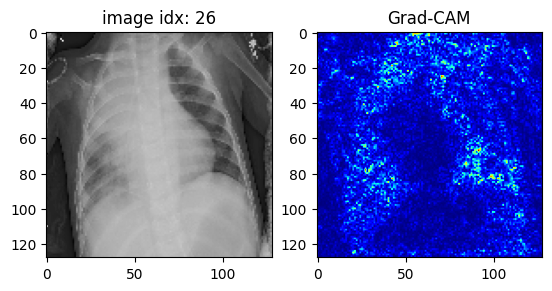

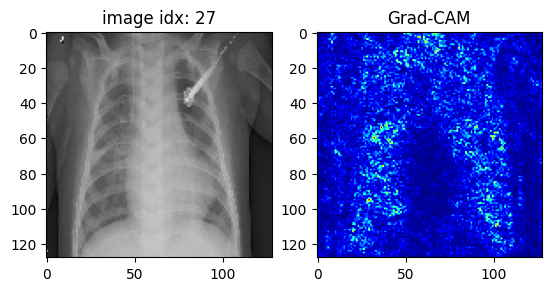

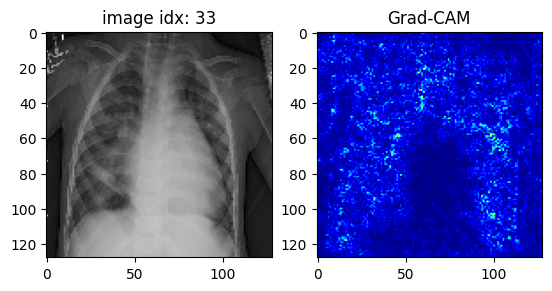

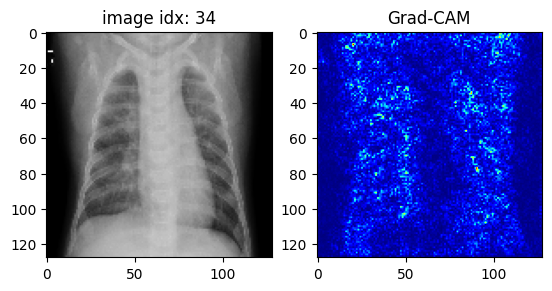

In [ ]:
for idx in cherry_pick:
  img = test_ds.img[idx].unsqueeze(0).cuda()
  cam = guided_backprop(img,mdl,ds.lbl[idx])
  cam = cam/cam.max()
  plot_cam(img,cam,idx,ds.lbl[idx])


In [ ]:
cam

tensor([[[[0.0052, 0.0012, 0.0141,  ..., 0.0060, 0.0076, 0.0075],
          [0.0511, 0.0238, 0.0092,  ..., 0.0036, 0.0272, 0.0205],
          [0.0525, 0.0040, 0.0223,  ..., 0.0055, 0.0394, 0.0523],
          ...,
          [0.0034, 0.0053, 0.0034,  ..., 0.0028, 0.0593, 0.0341],
          [0.0358, 0.0130, 0.0537,  ..., 0.0090, 0.0273, 0.0179],
          [0.0012, 0.0096, 0.0113,  ..., 0.0312, 0.0282, 0.0121]]]],
       device='cuda:0')

In [ ]:
cam.min()

tensor(6.3692e-06, device='cuda:0')

It looks like most of the important pixels are within the lung. However, the boundaries of more affected areas within the lung lobes are not visible. In addition, the shoulders are classified as similarly important in some images. A clear overfitting is not visible with a validation accuracy of >90%.
